<a href="https://colab.research.google.com/github/john-tseng-710/DL/blob/master/TL_VGG16_dogs_vs_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import glob
import PIL
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense

# Trnasfer Learning：ensemble pretrained VGG16 with self-defined MLP 

In [ ]:
# VGG16:
#   input_shape: conventionally use (224, 224, 3) as VGG16 model is trained using photos of this dimension
#   include_top: True: use original 10-class-MLP, False: use self-defined MLP
#   weights: defaultly use 'imagenet' pretrained weights
vgg = VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    )
vgg.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

# Data Preprocessing

In [32]:
# Do NOT read image until training starts
df = pd.DataFrame(columns=['path', 'label'])
for p in glob.glob('./sample_data/dogs_vs_cats/train/cat.*.jpg'):
  s = pd.Series([p, 0], index=['path', 'label'])
  df = df.append(s, ignore_index=True)
for p in glob.glob('./sample_data/dogs_vs_cats/train/dog.*.jpg'):
  s = pd.Series([p, 1], index=['path', 'label'])
  df = df.append(s, ignore_index=True)
df

,path,label
0,./sample_data/dogs_vs_cats/train/cat.10.jpg,0
1,./sample_data/dogs_vs_cats/train/cat.1076.jpg,0
2,./sample_data/dogs_vs_cats/train/cat.1298.jpg,0
3,./sample_data/dogs_vs_cats/train/cat.491.jpg,0
4,./sample_data/dogs_vs_cats/train/cat.1107.jpg,0
...,...,...
2169,./sample_data/dogs_vs_cats/train/dog.10900.jpg,1
2170,./sample_data/dogs_vs_cats/train/dog.3891.jpg,1
2171,./sample_data/dogs_vs_cats/train/dog.9044.jpg,1
2172,./sample_data/dogs_vs_cats/train/dog.992.jpg,1


(224, 224)
1


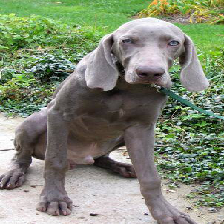

In [53]:
# Preview & Unify image size w/ keras.preprocessing.image.load_img('path', target_size=(?, ?)) 
random_idx = np.random.randint(0, 2173)
random_img = load_img(df['path'][random_idx], target_size=(224, 224))
print(random_img.size)
print(f"{df['label'][random_idx]}")
random_img

# Build Model

In [59]:
# VGG was built w/ keras.models.Model
# check VGG input/output
print(vgg.input)
print(vgg.output)

Tensor("input_1:0", shape=(None, 224, 224, 3), dtype=float32)
(None, 7, 7, 512)


In [58]:
stack = Flatten()(vgg.output)   # Flatten returns a function
stack = Dense(units=2048, activation='relu')(stack)  # Dense does the same 